In [1]:
import pandas as pd
import pylogit as pl
import numpy as np
import json
import math
import pickle
import random
from collections import OrderedDict
from shapely.geometry import shape, Point
from utilities import amenityHealthList, amenityRestaurantList, amenityEntertainmentList, amenitySchoolList, process_poi
import time
from os import path
import geopandas as gpd

## PUMS Data

(-90.81836909999997, -82.0132409, 41.36898389999999, 48.56593410000001)

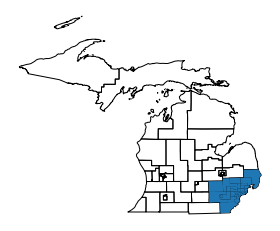

In [3]:
city='Detroit'
state_codes={'Detroit': 'mi', 'Boston': 'ma'}
state_fips={'Detroit': '26', 'Boston': '25'}
NUM_ALTS=8
sample_size=5000
PUMAS_INCLUDED_PATH='cities/'+city+'/raw/PUMS/pumas_included.json'
FITTED_HOME_LOC_MODEL_PATH='cities/'+city+'/models/home_loc_logit.p'
PUMA_POP_PATH='cities/'+city+'/raw/ACS/ACS_17_1YR_B01003/population.csv'
PUMS_HH_PATH='cities/'+city+'/raw/PUMS/csv_h'+state_codes[city]+'/ss16h'+state_codes[city]+'.csv'
PUMS_POP_PATH='cities/'+city+'/raw/PUMS/csv_p'+state_codes[city]+'/ss16p'+state_codes[city]+'.csv'
PUMA_SHAPE_PATH='cities/'+city+'/raw/PUMS/pumas.geojson'
POI_PATH = 'cities/'+city+'/raw/OSM/poi.geojson'
PUMA_TO_POW_PUMA_PATH='puma_to_pow_puma.csv'
RENT_NORM_PATH='cities/'+city+'/models/rent_norm.json'

hh=pd.read_csv(PUMS_HH_PATH)
pop = pd.read_csv(PUMS_POP_PATH)
hh['PUMA']=hh.apply(lambda row: str(int(row['PUMA'])).zfill(5), axis=1)
pop['PUMA']=pop.apply(lambda row: str(int(row['PUMA'])).zfill(5), axis=1)
pop['POWPUMA']=pop.apply(lambda row: str(int(row['POWPUMA'])).zfill(5) 
                        if not np.isnan(row['POWPUMA']) else 'NaN', axis=1)

all_PUMAs=list(set(hh['PUMA']))
pumas_included=json.load(open(PUMAS_INCLUDED_PATH))                 # For Southeast MI
# pumas_included = all_PUMAs                                          # For the whole MI
pumas_shape=json.load(open(PUMA_SHAPE_PATH))
pumas_order=[f['properties']['PUMACE10'] for f in pumas_shape['features']]
          
puma_pop=pd.read_csv(PUMA_POP_PATH)
puma_pop['PUMA']=puma_pop.apply(lambda row: str(row['GEO.id2'])[2:].zfill(5), axis=1)
puma_pop=puma_pop.set_index('PUMA')
# get the area of each PUMA
puma_land_sqm={str(int(f['properties']['PUMACE10'])).zfill(5): f['properties']['ALAND10']
                for f in pumas_shape['features']}

mi_pd = gpd.read_file(PUMA_SHAPE_PATH)
mi_pd['PUMA'] = mi_pd.apply(lambda row: str(int(row['PUMACE10'])).zfill(5), axis=1)
se_mi_pd = mi_pd[mi_pd['PUMA'].isin(pumas_included)].copy()
ax = mi_pd.plot(facecolor="none", edgecolor="black")  # michigan
se_mi_pd.plot(ax=ax)           #southeast michigan
ax.axis('off')


## Identify Recent Movers and Vacant Houses     

In [4]:
hh_vacant_for_rent=hh[(hh['VACS']==1) & (hh['PUMA'].isin(pumas_included))].copy()          
hh_rented=hh[(hh['TEN']==3) & (hh['PUMA'].isin(pumas_included))].copy()                                                      
renters_recent_move=hh_rented[hh_rented['MV']==1].copy()
print('Recent mover: {} cases.'.format(renters_recent_move.shape[0]))
print('Vacant houses: {} cases.'.format(hh_vacant_for_rent.shape[0]))

Recent mover: 5745 cases.
Vacant houses: 847 cases.


## Calculate Home-Workplace Distance

In [5]:
def get_haversine_distance(point_1, point_2):
    """
    Calculate the distance between any 2 points on earth given as [lon, lat]
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [point_1[0], point_1[1], 
                                                point_2[0], point_2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# =============================================================================
# Distance Matrix
# =============================================================================
# get the distance between each puma and each pow-puma
# first get a lookup between pow-pumas and pumas
# because we only have the shapes of the PUMAS
pow_puma_df=pd.read_csv(PUMA_TO_POW_PUMA_PATH, skiprows=1, header=1)
pow_puma_df_state=pow_puma_df.loc[pow_puma_df[
        'State of Residence (ST)']==state_fips[city]].copy()
pow_puma_df_state['POW_PUMA']=pow_puma_df_state.apply(
        lambda row: str(int(row['PWPUMA00 or MIGPUMA1'])).zfill(5), axis=1)
pow_puma_df_state['PUMA']=pow_puma_df_state.apply(
        lambda row: str(int(row['PUMA'])).zfill(5), axis=1)
all_pow_pumas=set(pow_puma_df_state['POW_PUMA'])
pow_puma_to_puma={}
for p in all_pow_pumas:
    pow_puma_to_puma[p]=list(pow_puma_df_state.loc[
            pow_puma_df_state['POW_PUMA']==p, 'PUMA'].values)

# find the centroid of each puma
puma_centroids={}
pow_puma_centroids={}
for puma in set(pow_puma_df_state['PUMA']):
    centr=shape(pumas_shape['features'][pumas_order.index(puma)]['geometry']).centroid
    puma_centroids[puma]=[centr.x, centr.y]
    
# and each pow-puma
all_pow_pumas=set(pow_puma_df_state['POW_PUMA'])

for pow_puma in all_pow_pumas:
    pumas=pow_puma_to_puma[pow_puma]
    puma_centr=[puma_centroids[puma] for puma in pumas]
    # TODO, shold be weighted by area- ok if similar size
    pow_puma_centroids[pow_puma]=[np.mean([pc[0] for pc in puma_centr]),
                                  np.mean([pc[1] for pc in puma_centr])]
dist_mat={}
for puma in puma_centroids:
    dist_mat[puma]={}
    for pow_puma in pow_puma_centroids:
        dist = get_haversine_distance(
                puma_centroids[puma], pow_puma_centroids[pow_puma])
        if dist > 0:
            dist_mat[puma][pow_puma] = dist
        else:
            dist_mat[puma][pow_puma] = np.sqrt(puma_land_sqm[puma] / np.pi) # set inner distance to quasi-radius

for puma in list(dist_mat.keys())[:3]:
    for pow_puma in list(dist_mat[puma].keys())[:3]:
        print('from puma={} to pow_puma={}: {}'.format(puma, pow_puma, dist_mat[puma][pow_puma]))
    print('......')

from puma=02905 to pow_puma=00800: 210984.29319671384
from puma=02905 to pow_puma=01100: 174324.8101466265
from puma=02905 to pow_puma=01700: 58213.554826038155
......
from puma=03206 to pow_puma=00800: 246992.38659815423
from puma=03206 to pow_puma=01100: 220309.78069879994
from puma=03206 to pow_puma=01700: 106963.96538439141
......
from puma=01004 to pow_puma=00800: 43903.472767123
from puma=01004 to pow_puma=01100: 42951.269334498145
from puma=01004 to pow_puma=01700: 152468.8785364652
......


## Calculate Amenity Density

In [6]:
# =============================================================================
# Amenity Density
# =============================================================================
# a poiConfigure is a dict indicating how different kinds of POIs are extracted and summarized. 
# Each key of poiConfigure is one category of POIs to be finally summarized, 
# its value is a dict as extracting rules indicating which OSM points would be categorized as this kind of POI.
# The keys of these extracting rules are OSM keys, and values are lists of OSM values to be extracted,
# an empty list indicates all OSM values under that OSM key will be extracted.
poiConfigure = {
    'entertainment': {'amenity': amenityEntertainmentList + amenityRestaurantList,
            'leisure': [],
            'shop':[]
    },
}
print('\n[info] Processing POIs...')
PUMAsJointPOIsData = process_poi(POI_PATH, PUMA_SHAPE_PATH, poiConfigure)
poiFields = [x+'_den' for x in poiConfigure]
puma_poi_dict = {str(int(x['properties']['PUMACE10'])).zfill(5):x['properties'] for x in PUMAsJointPOIsData['features']}


[info] Processing POIs...

[info] Extracting "entertainment" from "poi.geojson"
[info] Spatial joining "entertainment" to "pumas.geojson"


## Data Preparing

### Housing unit level: norm rent, number of rooms, built year, income, number of persons

### PUMA level: median income, median norm rent, population density, number of available housing units

In [7]:
# build the PUMA aggregate data data frame
median_income_by_puma=hh.groupby('PUMA')['HINCP'].median()
#TODO: get more zonal attributes such as access to employment, amenities etc.

puma_obj=[{'PUMA':puma,
           'med_income':median_income_by_puma.loc[puma],
           'puma_pop_per_sqm':float(puma_pop.loc[puma]['HD01_VD01'])/puma_land_sqm[puma]
           } for puma in pumas_included]
puma_attr_df=pd.DataFrame(puma_obj)
for poiField in poiFields:
    puma_attr_df[poiField] = puma_attr_df.apply(lambda row: puma_poi_dict[row['PUMA']][poiField], axis=1)
puma_attr_df=puma_attr_df.set_index('PUMA')

# create features at property level
# normalise rent stratifying by bedroom number
renters_recent_move.loc[renters_recent_move['BDSP']>2, 'BDSP']=3            # change [the number of bedroom] >2 to 3
renters_recent_move.loc[renters_recent_move['BDSP']<1, 'BDSP']=1            # change [the number of bedroom] <1 to 1
hh_vacant_for_rent.loc[hh_vacant_for_rent['BDSP']>2, 'BDSP']=3          
hh_vacant_for_rent.loc[hh_vacant_for_rent['BDSP']<1, 'BDSP']=1
rent_mean={}
rent_std={}
for beds in range(1,4):
    rent_mean[beds]=renters_recent_move.loc[renters_recent_move['BDSP']==beds, 'RNTP'].mean()
    rent_std[beds]=renters_recent_move.loc[renters_recent_move['BDSP']==beds, 'RNTP'].std()
    
for df in [renters_recent_move, hh_vacant_for_rent]:
    df['norm_rent']=df.apply(
        lambda row: (row['RNTP']-rent_mean[row['BDSP']])/rent_std[row['BDSP']], axis=1)
    # Age of building
    df['built_since_jan2010']=df.apply(lambda row: row['YBL']>=14, axis=1)
    df['puma_pop_per_sqmeter']=df.apply(lambda row: puma_attr_df.loc[row['PUMA']]['puma_pop_per_sqm'], axis=1)
    df['med_income']=df.apply(lambda row: puma_attr_df.loc[row['PUMA']]['med_income'], axis=1)  
all_rooms_available = pd.concat([hh_vacant_for_rent, renters_recent_move], axis=0) 
median_norm_rent = all_rooms_available.groupby('PUMA')['norm_rent'].median()
puma_attr_df['media_norm_rent'] =  puma_attr_df.apply(lambda row: median_norm_rent[row.name], axis=1)

# num of avaiable housing units in each PUMA
num_available_houses_in_puma = hh_vacant_for_rent.groupby('PUMA')['SERIALNO'].count()
puma_attr_df['num_houses'] = puma_attr_df.apply(lambda row: num_available_houses_in_puma[row.name], axis=1)

renters_recent_move=renters_recent_move[['SERIALNO', 'PUMA','HINCP',  'norm_rent', 'RNTP', 'built_since_jan2010', 'puma_pop_per_sqmeter', 'med_income', 'BDSP', 'NP']]
hh_vacant_for_rent=hh_vacant_for_rent[['PUMA', 'HINCP', 'norm_rent', 'RNTP','built_since_jan2010', 'puma_pop_per_sqmeter', 'med_income', 'BDSP']]
 
rent_normalisation={"mean": rent_mean, "std": rent_std}   

## 2-stage Logit Model

reference: Modeling the Choice of Residential Location and Home Type: Recent Movers in Austin, Texas

![title](2-stage.png)

## 1st Stage (PUMA Level) Data Preparation

In [10]:
# =============================================================================
# Model Estimation
# First stage: choice model on PUMA level
# =============================================================================
long_data_PUMA = pd.DataFrame()
print('[info] Preparing long data for PUMA-level choice.')
time1 = time.time()
numPUMAs = puma_attr_df.shape[0]
ind = 0
for ind_actual, row_actual in renters_recent_move.iterrows():
    if ind >= sample_size:
        break
    householdID = row_actual['SERIALNO']
    places_of_work = set(pop.loc[pop['SERIALNO']==householdID, 'POWPUMA'])
    places_of_work = [x for x in places_of_work if x in all_pow_pumas]
    if len(places_of_work):
        this_sample_puma_attr_df = puma_attr_df.copy()
        this_sample_puma_attr_df['custom_id'] = ind_actual * np.ones(numPUMAs, dtype=np.int8)
        this_sample_puma_attr_df['choice_id'] = list(puma_attr_df.index)
        this_sample_puma_attr_df['choice'] = np.zeros(numPUMAs)
        this_sample_puma_attr_df['hh_income'] = row_actual['HINCP']
        this_sample_puma_attr_df.loc[this_sample_puma_attr_df['choice_id']==row_actual['PUMA'], 'choice'] = 1
        this_sample_puma_attr_df['work_dist'] = [np.mean([dist_mat[puma][pow_puma] 
                                              for pow_puma in places_of_work]) for puma in list(puma_attr_df.index)]
        long_data_PUMA = pd.concat([long_data_PUMA, this_sample_puma_attr_df], axis=0)
        ind += 1

long_data_PUMA['income_disparity']=long_data_PUMA.apply(lambda row: np.abs(row['hh_income']-row['med_income']), axis=1)
time2 = time.time()
print('[info] Long data for PUMA-level choice finished. Elapsed time: {} seconds'.format(time2-time1))
long_data_PUMA.to_csv('cities/'+city+'/clean/logit_data_long_form/logit_data_PUMA.csv', index=False)
print(long_data_PUMA.head())

[info] Preparing long data for PUMA-level choice.
[info] Long data for PUMA-level choice finished. Elapsed time: 112.41253089904785 seconds
       med_income  puma_pop_per_sqm  entertainment_den  media_norm_rent  \
PUMA                                                                      
02701     80000.0          0.000076       1.223543e-07         0.077615   
02702     59250.0          0.001609       1.079262e-05         0.674951   
02703     54000.0          0.000463       7.162070e-07        -0.071435   
02800     76000.0          0.000130       1.065799e-07        -0.101939   
02901     76300.0          0.000190       2.598215e-07        -0.134548   

       num_houses  custom_id choice_id  choice  hh_income     work_dist  \
PUMA                                                                      
02701           2         51     02701     0.0    60000.0  85347.290613   
02702          17         51     02702     0.0    60000.0  73017.119325   
02703          27         51     0

## 1st Stage (PUMA Level) Model Estimation

In [12]:
choiceModelPUMA_spec = OrderedDict()
choiceModelPUMA_names = OrderedDict()
choiceModelPUMAsRegressors = ['puma_pop_per_sqm', 'income_disparity', 'work_dist', 'media_norm_rent', 'num_houses'] + [x for x in list(long_data_PUMA.columns) if x.endswith('_den')]
for var in choiceModelPUMAsRegressors:
    choiceModelPUMA_spec[var] = [list(set(long_data_PUMA['choice_id']))]
    choiceModelPUMA_names[var] = [var]
    
home_loc_mnl_PUMAs = pl.create_choice_model(data=long_data_PUMA,
                                        alt_id_col='choice_id',
                                        obs_id_col='custom_id',
                                        choice_col='choice',
                                        specification=choiceModelPUMA_spec,
                                        model_type="MNL",
                                        names=choiceModelPUMA_names)
print('[info] Fitting Upper Level Model')
numCoef=sum([len(choiceModelPUMA_spec[s]) for s in choiceModelPUMA_spec])
# pylogit may encounter memory error in calculating Hessiann matrix for S.E. in this model, if so, switch to noHessian approach and only do point estimation.
try:
    home_loc_mnl_PUMAs.fit_mle(np.zeros(numCoef))
    print(home_loc_mnl_PUMAs.get_statsmodels_summary())
except:
    home_loc_mnl_PUMAs_result = home_loc_mnl_PUMAs.fit_mle(np.zeros(numCoef), just_point=True)
    params = home_loc_mnl_PUMAs_result['x']
    print('\nLogit model parameters:\n---------------------------')
    for varname, para in zip(home_loc_mnl_PUMAs.ind_var_names, params):
        print('{}: {:4.6f}'.format(varname, para))

C:\Users\wangc\Anaconda3\lib\site-packages\pylogit\choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


[info] Fitting Upper Level Model
Log-likelihood at zero: -14,527.9889
Initial Log-likelihood: -14,527.9889


C:\Users\wangc\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 3.04 seconds.
Final log-likelihood: -11,243.8031


C:\Users\wangc\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)



Logit model parameters:
---------------------------
puma_pop_per_sqm: -647.778225
income_disparity: -0.000019
work_dist: -0.000085
media_norm_rent: -0.179001
num_houses: 0.001534
entertainment_den: 117193.997910


## 2nd Stage (Housing Units Level) Data Preparation

In [14]:
# =============================================================================
# Model Estimation
# Second stage: choice model on HH level
# =============================================================================
random.seed(1)
print('[info] Preparing long data for HH-level choice.')
long_data_hh_obj = []
ind=0
time1 = time.time()
for ind_actual, row_actual in renters_recent_move.iterrows():
    if ind >= sample_size:
        break
    cid=1
    householdID = row_actual['SERIALNO']
    thisPUMA = row_actual['PUMA']
    places_of_work = set(pop.loc[pop['SERIALNO']==householdID, 'POWPUMA'])
    places_of_work = [x for x in places_of_work if x in all_pow_pumas]
    
    if len(places_of_work):
        # this is the real choice
        choiceObs={'custom_id':ind, # identify the individual
                   'choice_id':cid, # fake choice identifier- shouldn't matter if no ASC
                   'choice':1,
                   'rent':row_actual['RNTP'],
                   'norm_rent':row_actual['norm_rent'],
                   'puma':row_actual['PUMA'],
                   'built_since_jan2010':int(row_actual['built_since_jan2010']),
                   'bedrooms': row_actual['BDSP'],
                   'hh_income':row_actual['HINCP'],
                   'nPersons':row_actual['NP']
                   }

        cid+=1
        long_data_hh_obj.append(choiceObs)
        
        hh_vacant_for_rent_in_this_PUMA = hh_vacant_for_rent.loc[hh_vacant_for_rent['PUMA']==thisPUMA].copy()
        
        for i in range(NUM_ALTS):
            selected=random.choice(range(len(hh_vacant_for_rent_in_this_PUMA)))
            alt_obs={'custom_id':ind,# identify the individual
                     'choice_id':cid, # fake choice identifier- shouldn't matter if no ASC
                     'choice':0,
                     'rent':hh_vacant_for_rent_in_this_PUMA.iloc[selected]['RNTP'],
                     'norm_rent':hh_vacant_for_rent_in_this_PUMA.iloc[selected]['norm_rent'],
                     'puma':hh_vacant_for_rent_in_this_PUMA.iloc[selected]['PUMA'],
                     'built_since_jan2010':int(hh_vacant_for_rent_in_this_PUMA.iloc[selected]['built_since_jan2010']),
                     'bedrooms': hh_vacant_for_rent_in_this_PUMA.iloc[selected]['BDSP'],
                     'hh_income':row_actual['HINCP'],
                     'nPersons':row_actual['NP']
                     }
            cid+=1
            long_data_hh_obj.append(alt_obs)
        ind+=1

long_data_hh=pd.DataFrame(long_data_hh_obj)  
long_data_hh['income_norm_rent'] = long_data_hh['hh_income'] * long_data_hh['norm_rent']
long_data_hh['income_bedrooms'] = long_data_hh['hh_income'] * long_data_hh['bedrooms']
long_data_hh['nPerson_bedrooms'] = long_data_hh['nPersons'] * long_data_hh['bedrooms']
time2 = time.time()
print('\n[info] Long data for HH-level choice finished. Elapsed time: {} seconds\n'.format(time2-time1))
long_data_hh.to_csv('cities/'+city+'/clean/logit_data_long_form/logit_data_hh.csv', index=False)
print(long_data_hh.head())

[info] Preparing long data for HH-level choice.

[info] Long data for HH-level choice finished. Elapsed time: 54.30593538284302 seconds

   bedrooms  built_since_jan2010  choice  choice_id  custom_id  hh_income  \
0       3.0                    0       1          1          0    60000.0   
1       3.0                    0       0          2          0    60000.0   
2       1.0                    0       0          3          0    60000.0   
3       1.0                    0       0          4          0    60000.0   
4       3.0                    0       0          5          0    60000.0   

   nPersons  norm_rent   puma    rent  income_norm_rent  income_bedrooms  \
0         4  -0.101939  03100   900.0      -6116.319698         180000.0   
1         4   0.101110  03100  1000.0       6066.605271         180000.0   
2         4  -0.234912  03100   620.0     -14094.725274          60000.0   
3         4   1.650253  03100  1400.0      99015.171217          60000.0   
4         4  -0.1019

## 2nd Stage (Housing Units Level) Model Estimation

In [15]:
choiceModelHH_spec = OrderedDict()
choiceModelHH_names = OrderedDict()
choiceModelHHRegressors = ['norm_rent', 'built_since_jan2010', 'bedrooms', 'income_norm_rent', 'income_bedrooms', 'nPerson_bedrooms']

for var in choiceModelHHRegressors:
    choiceModelHH_spec[var] = [list(set(long_data_hh['choice_id']))]
    choiceModelHH_names[var] = [var]

home_loc_mnl_hh = pl.create_choice_model(data=long_data_hh,
                                        alt_id_col='choice_id',
                                        obs_id_col='custom_id',
                                        choice_col='choice',
                                        specification=choiceModelHH_spec,
                                        model_type="MNL",
                                        names=choiceModelHH_names)

# Specify the initial values and method for the optimization.
print('[info] Fitting Model')
numCoef=sum([len(choiceModelHH_spec[s]) for s in choiceModelHH_spec])

try:
    home_loc_mnl_hh.fit_mle(np.zeros(numCoef))
    print(home_loc_mnl_hh.get_statsmodels_summary())
except:
    home_loc_mnl_hh_result = home_loc_mnl_hh.fit_mle(np.zeros(numCoef), just_point=True)
    params = home_loc_mnl_hh_result['x']
    print('\nLogit model parameters:\n---------------------------')
    for varname, para in zip(home_loc_mnl_hh_result.ind_var_names, params):
        print('{}: {:4.6f}'.format(varname, para))
 

C:\Users\wangc\Anaconda3\lib\site-packages\pylogit\choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


[info] Fitting Model
Log-likelihood at zero: -9,129.4681
Initial Log-likelihood: -9,129.4681


C:\Users\wangc\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.16 seconds.
Final log-likelihood: -8,301.5714
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                      choice   No. Observations:                4,155
Model:             Multinomial Logit Model   Df Residuals:                    4,149
Method:                                MLE   Df Model:                            6
Date:                     Thu, 12 Sep 2019   Pseudo R-squ.:                   0.091
Time:                             23:11:41   Pseudo R-bar-squ.:               0.090
AIC:                            16,615.143   Log-Likelihood:             -8,301.571
BIC:                            16,653.135   LL-Null:                    -9,129.468
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
norm_rent              -0.3155      0.030    -10.354      0.000   